In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/embeddings/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','crossref')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in datasets:
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/crossref/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/embeddings/glove-300.matrix.npy',
                        text_columns = ['title', 'authors', 'venue'],
                        numeric_columns = [],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine'],
                        text_compositions=['average'],
                        numeric_sim_metrics=[],
                        dense_nodes=[32, 16, 8],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=False)

W0714 11:48:43.073492  9732 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0714 11:48:43.216746  9732 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0714 11:49:15.850748  9732 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0714 11:49:15.859724  9732 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0714 11:49:15.859724  9732 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backen

Number of inputs to dense layer: 3


# Train model 

In [4]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, batch_size=8192,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

W0714 11:50:13.174670  9732 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0714 11:50:13.222166  9732 deprecation.py:323] From D:\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 42776 samples, validate on 5347 samples
Epoch 1/1
42776/42776 [==============================] - 6s 132us/step - loss: 0.7010 - acc: 0.3524 - val_loss: 0.6729 - val_acc: 0.8687


# Learning curves

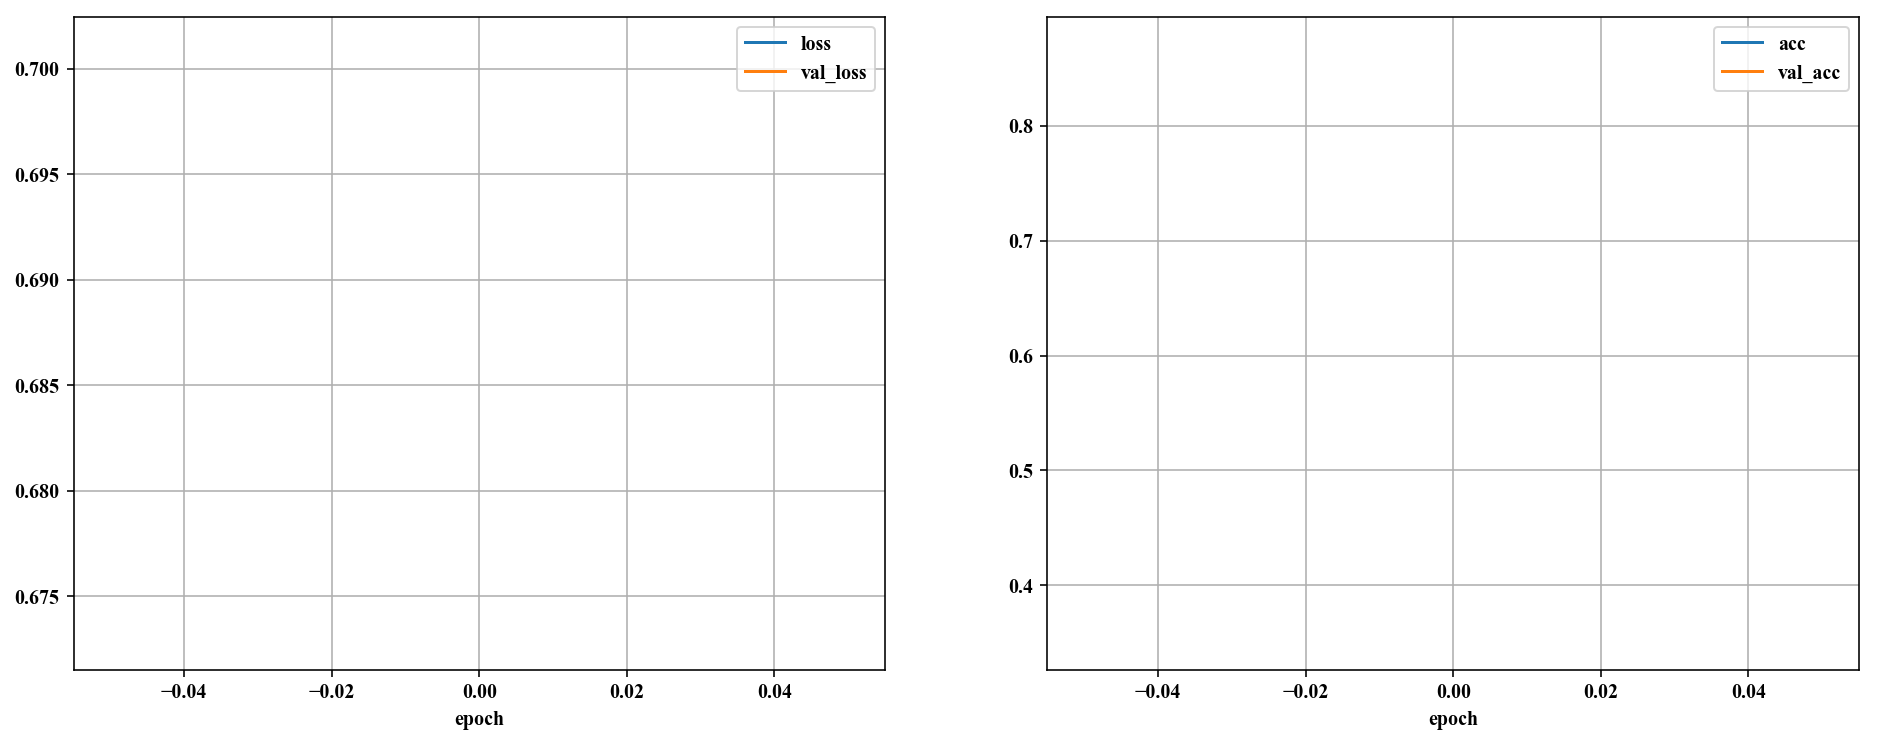

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [6]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      4840
           1       0.34      0.40      0.37       507

   micro avg       0.87      0.87      0.87      5347
   macro avg       0.64      0.66      0.65      5347
weighted avg       0.88      0.87      0.87      5347

[[4441  399]
 [ 303  204]]


In [7]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['title', 'authors', 'venue']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(5)

,id1,title,authors,venue,year,id2,title,authors,venue,year
2746,conf/vldb/DonjerkovicR99,Probabilistic Optimization of Top N Queries,"D <unk> , R Ramakrishnan",VLDB,1999,4U31XD8P478J,Probabilistic optimization of top n queries,DDR Ramakrishnan,<unk>,1999.0
1424,journals/sigmod/AtkinsonDJPS96,An Orthogonally Persistent Java,"M Atkinson , L <unk> , M Jordan , T Printezis , S Spence",SIGMOD Record,1996,5tuINV43CDUJ,"L. , JORDAN , MJ , Printezis , T. , AND SPENCE , S. 1996. An orthogonally persistent java","MP ATKINSON , ES DAYN",SIGMOD,0.0
5292,journals/sigmod/SchmidtWKFCMB01,Why And How To Benchmark XML Databases,"A Schmidt , F Waas , M Kersten , D Florescu , M Carey , I Manolescu , R Busse",SIGMOD Record,2001,mkfP-JNsNZoJ,Why And How To Benchmark XML Databases [ Z ] . proceeding of SIGMOD international conference,"A Schmidt , F Was , M <unk> ? <unk>",<unk>,2001.0
4755,conf/sigmod/BozkayaO97,Distance-Based Indexing for High-Dimensional Metric Spaces,"T <unk> , Z <unk>",SIGMOD Conference,1997,9QOCoTIXz9kJ,<unk> for high dimensional metric spaces,TBM <unk>,"Proc. of SIGMOD ,",0.0
1528,journals/vldb/DesslochHMMT98,"Advanced Data Processing in <unk> : Modeling Concepts , Implementation Techniques , and Client / Server Issues","S <unk> , T <unk> , N Mattos , B <unk> , J Thomas",VLDB J.,1998,4D2HQE6fXXEJ,"Advanced data processing in <unk> : modeling concepts , implementation techniques , and client / server","S <unk> ? loch , T <unk> , N Mattos , B <unk> , J","The VLDB Journal The International Journal on Very Large … ,",1998.0


# Save model and histories 

In [8]:
pd.DataFrame(histories).to_csv('../data/histories/crossref-base-1.csv', index=False)
model.save_weights('../data/models/crossref-base-1')

# Test model 

In [9]:
model.load_weights('../data/models/crossref-base-1')
y_test_pred = model.predict(X_test, batch_size=8102)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

              precision    recall  f1-score   support

           0    0.93287   0.91661   0.92467      4821
           1    0.34098   0.39544   0.36620       526

   micro avg    0.86535   0.86535   0.86535      5347
   macro avg    0.63693   0.65603   0.64543      5347
weighted avg    0.87464   0.86535   0.86973      5347

[[4419  402]
 [ 318  208]]
